# INF8775 – Analyse et conception d’algorithmes
# TP2 – Hiver 2024

Denis, Simon, 2152269

Mili, Haroun, 2144744

Note finale :

 <u>**Date limite de remise :**</u>  27 mars 23h59 (Groupe B1), 19 mars 23h59 (Groupe B2)

# Instructions

## Rédaction et remise du rapport

- Ce notebook constitue à la fois le sujet du TP, votre code et votre rapport. Il contient déjà du code pour faciliter vos mesures et l'affichage de vos résultats, ainsi qu'un squelette pour votre rapport.

- Complétez directement le notebook, vous êtes libres de créer de nouvelles cellules de code ou de texte. 

- Remettez le fichier du notebook sur Moodle avec le nom `NOM1_MATRICULE1_NOM2_MATRICULE2.ipynb`

- Vous pouvez inclure du code trouvé sur Internet, mais vous devez en mentionner la source, sous peine d'être sanctionnés pour plagiat.

## Mise en situation

Ce travail pratique se répartit sur deux séances de laboratoire et porte sur l'analyse et la conception d'algorithmes développés suivant différents patrons de conception afin de résoudre une version simplifiée d'un problème réaliste d'optimisation.


## Description du problème

Un pianiste souhaite jouer une mélodie donnée par une partition. La mélodie est une suite de n notes *(a0, a1, ... , an-1)* où chaque ai appartient à un ensemble de m notes numérotées de 0 à m-1.

Le pianiste peut choisir de jouer chaque note avec l’un de ses D doigts. Le passage de la note i1 jouée avec le doigt d1 à la note i2 jouée avec le doigt d2 est pénalisée par une fonction de difficulté de la transition *C(i1, d1, i2, d2)*. Notre pianiste souhaite donc déterminer avec quel doigt il doit jouer chaque note de la mélodie de façon à minimiser la somme des coûts de chaque transition.

Pour la partie empirique de ce TP, nous nous limiterons à des mélodies jouées à une main (D=5) sur deux octaves (m=24).

Soit l’exemple suivant avec 5 notes :

- L'exemplaire est : `[17, 21, 18, 2, 21, 15, 11, 16]`
- La solution est : `[2, 1, 1, 0, 1, 1, 2, 1]`

La figure ci-dessous représente la partition avec ça solution et le coût associé à chaque transition (en gris).

![alt text](example_solution.png "Title")

## Algorithmes à implanter

Trois algorithmes seront implantés, mettant en pratique des patrons de conception différents :

1. Un algorithme glouton
2. Un algorithme de programmation dynamique
3. Un algorithme de recherche locale


## Jeu de données

La fonction `generate_sample` ci-dessous permet de générer un exemplaire d'une taille donnée.

La fonction `get_dataset` permet de récupérer un dataset pour la liste de taille fournie. Elle prend également en entrée un graine aléatoire pour générer le dataset en question.

Afin que chaque groupe travaille avec un set différent, mais que vos propres expériences soient reproductibles, entrez l'un de vous matricule comme graine aléatoire dans la cellule ci-dessous.

Vous êtes bien entendu libres de tester et mesurer vos algorithme sur le même dataset qu'un autre groupe. Pour cela, générez simplement un dataset avec la même graine et la même liste de taille.



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.stats import linregress
import time
import sys

In [3]:
def visualize_solution(costs, partition, solution):
    """
    Visualisez votre solution et les coûts associés.    
    """
    # Create a figure and axis
    _, ax = plt.subplots()
    
    # Plot the notes as circles with their sizes proportional to the partition values
    for i in range(len(partition)):
        ax.scatter([i], [partition[i]], marker='o')
        ax.text(i, partition[i] + 0.2, str(solution[i]), ha='center', va='bottom')
    
    # Set the limits for the axes to fit the plot
    ax.set_ylim(min(partition) - 1, max(partition) + 1)
    ax.set_xlim(-0.5, len(partition)-0.5)
    
    # Label the axes
    ax.set_xlabel('Partition')
    ax.set_ylabel('Note')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Title the plot
    ax.set_title('Partition et doigts utilisés')

    plot_costs = getCosts(costs, partition, solution).tolist()
    plot_costs.append(0)

    ax2 = ax.twinx()
    ax2.bar(range(len(partition)), plot_costs, width=1, alpha=0.5, align='edge', color='gray')
    ax2.set_xlim(-0.5, len(partition)-0.5)
    ax2.set_ylim(0, 100)
    
    # Remove the ticks and tick labels from the secondary y-axis
    ax2.tick_params(axis='both', which='both', length=0)
    ax2.set_yticklabels([])
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)    
    # Show the plot
    plt.show()

def generate_sample(size, maxValue=24):
    return np.random.randint(0, maxValue, size).tolist()

def get_dataset(seed, sizes):
    np.random.seed(seed)
    return { size: [generate_sample(size) for _ in range(5)]
        for size in sizes }

def readFile(filePath):
    """
    Charger une partition depuis un fichier
    """
    f = open(filePath)
    N = int(f.readline())
    partition = list(map(int, f.readline().split(' ')))
    f.close()
    return partition

def getCosts(costs, partition, solution):
    """
    Liste des coûts associés à chaque transition de votre solution.
    """
    prevNotes, nextNotes = partition[:-1], partition[1:]
    prevFingers, nextFingers = solution[:-1], solution[1:]
    return costs[prevNotes, prevFingers, nextNotes, nextFingers]

def getTotalCost(costs, partition, solution):
    """
    Coût total de votre solution
    """
    return np.sum(getCosts(costs, partition, solution))

Exécutez la cellule suivante afin d'obtenir le tenseur des coûts associé à chaque transition.

In [4]:
load_file = np.loadtxt('cout_transition.txt', dtype=int)
costs = load_file.reshape((24, 5, 24, 5))
D = 5    # Nombre de doigts
M = 24   # Etendue des notes (2 octaves)

partition = readFile('Chansons/twinkle_twinkle.txt')

# Implantations et expérimentations

Ces fonctions auxiliaires vous sont fournies pour vérifier l'exactitude des vos algorithmes, mesurer leurs performance et afficher vos résultats.

Il est recommandé de prendre le temps de lire et comprendre le code.

Exécutez la cellule ci-dessous pour pouvoir utiliser les fonctions auxiliaires.

In [5]:
def measure(procedure, sample):
    """ Mesure le temps d'execution d'une procédure sur un unique exemplaire """
    start = time.time()
    solution = procedure(sample)
    end = time.time()
    sorting_time = end - start
    return solution, sorting_time


def measure_mean_time(procedure, samples):
    total_time = 0
    for i in range(len(samples)):
        sample = samples[i]
        _, compute_time = measure(procedure, sample)
        total_time += compute_time
        print(f"Computing {procedure.__name__} on sample {i+1} of size {len(sample)}...          ", end='\r')
    return total_time / len(samples)


def measure_procedure(procedure, dataset):
    """ Mesure les temps moyens d'execution d'une procédure sur chaque point d'un dataset """
    return {size: measure_mean_time(procedure, samples) for size, samples in dataset.items()}

def display_measures_table(measures):
    print("{: <12} {: <12}".format("Taille", "Temps moyen (s)"))
    for size, measure in measures.items():
        print("{: <12} {: <12}".format(size, measure))


def display_test_puissance(vals, title="Test de puissance"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)
    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2f}x + {b:.2f}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label=f'Regression linéaire R²={round(rvalue**2,4)}')

    # Add labels and title
    plt.xlabel('log Taille')
    plt.ylabel('log Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

def display_test_rapport(vals, title="Test du rapport"):
    x = list(vals.keys())
    y = list(vals.values())

    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel('Taille')
    plt.ylabel('Temps / f(taille)')
    plt.title(title)
    plt.show()


def display_test_constantes(vals, title="Test des constantes"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)

    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2E}x + {b:.2E}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label=f'Regression linéaire R²={round(rvalue**2,4)}')

    # Add labels and title
    plt.xlabel('f(Taille)')
    plt.ylabel('Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

## Partie 1 : Algorithme glouton

Implantez un algorithme suivant le patron de conception glouton.

L'algorithme glouton fait son choix en fonction du coût de la prochaine transition :

Les deux premiers doigts d0 et d1 sont choisis de façon à minimiser C(a0, d0, a1, d1). Puis, étant donné le
doigt précédent d et la transition de la note i vers la note j, le choix glouton porte sur le doigt d’ qui
minimise C(i, d, j, d’).

Tentez de rendre votre implantation la plus performante possible en évitant des calculs inutiles.

Coût Glouton : 55


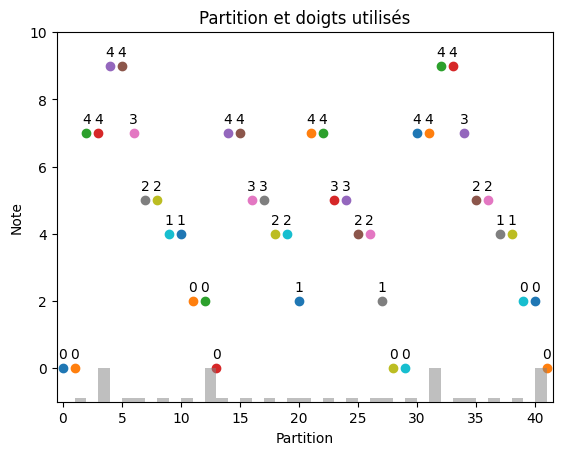

In [59]:
def glouton(partition, doigts = D):
    solution = [0]
    for i in range(1, len(partition)):
        smallest_cost = sys.maxsize
        next_finger = solution[i-1]
        if partition[i] <= partition[i - 1]:
            for j in range(doigts):
                next_finger_cost = costs[partition[i-1], solution[i-1], partition[i], j]
                if next_finger_cost <= smallest_cost:
                    smallest_cost = next_finger_cost
                    next_finger = j
        else: 
            for j in range(doigts-1, 0, -1):
                next_finger_cost = costs[partition[i-1], solution[i-1], partition[i], j]
                if next_finger_cost <= smallest_cost:
                    smallest_cost = next_finger_cost
                    next_finger = j
        solution.append(next_finger)
    return solution

solutionGlouton = glouton(partition)
print("Coût Glouton :", getTotalCost(costs, partition, solutionGlouton))
visualize_solution(costs, partition, solutionGlouton)

### Analyse asymptotique

Dans cette analyse, vous tiendrez compte à la fois de la longueur de la mélodie mais également du
nombre de doigts pour chacun des trois algorithmes.

La complexité temporelle dépend de la longueur de la partition passé en paramètre ainsi que du nombre de doigts. Dans notre algorithme, nous avons une boucle principale qui itère sur la longueur de la partition et une boucle imbriqué qui itère sur le nombre de doigts. En réalité, on retrouve deux boucles qui itère sur le nombre de doigts, mais une seule des deux boucles va être exécuté à chaque itération de la boucle principale(explication de notre raisonement pour les deux boucles à la fin de ce paragraphe). Alors, puisque nous avons une boucle principale qui itère sur la longueur de la partition et une boucle qui itère sur le nombre de doigts, la complexité temporelle de notre algorithme est O(n * D), où n est la longueur de la partition et D est le nombre de doigts. Le reste des opérations faites à l'intérieur des boucles sont faites en temps constant. En ce qui concerne les deux boucles dans notre boucles principales, nous avons simplement vérifié si la prochaine note a joué est plus élevé ou plus basse que la note actuelle. Si la prochaine note est moins élevé, on va itérer sur les doigts de 0 à D, sinon on va itérer sur les doigts de D à 0. Donc, une seule des deux boucles va être exécuté à chaque itération de la boucle principale. Donc, la complexité temporelle de notre algorithme reste O(n * D). La raison pourquoi nous avons fait cette vérification est simplement puisque nous avons remarqué que le coût total de la séquence est mieux optimisé. C'est logique puisque desfois plus d'un doigt va avoir le même coût optimal, alors notre boucle va les comparer de 0 à D lorsque la prochaine note est moins élevé et de D à 0 lorsque la prochaine note est plus élevé.

### Mesures

Rapportez dans un tableau les temps d'exécutions moyens avec les fonctions auxiliaires `measure_procedure` et `display_measure_table`

In [62]:
dataset = get_dataset(2152269, [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200])

In [63]:
measures_glouton = measure_procedure(glouton, dataset)
measures_glouton
display_measures_table(measures_glouton)

Taille       Temps moyen (s)5 of size 51200...          
100          0.00020208358764648438
200          0.0006014823913574219
400          0.0008321285247802734
800          0.0028028964996337892
1600         0.0050507068634033205
3200         0.01812324523925781
6400         0.017650842666625977
12800        0.03239450454711914
25600        0.06417174339294433
51200        0.12931065559387206


### Validation empirique

Servez-vous de vos temps d'exécution pour confirmer et/ou préciser l'analyse asymptotique théorique de vos algorithmes avec la méthode hybride de votre choix.

La méthode peut varier d'un algorithme à l'autre. Justifiez les choix ici et avec des graphiques.

**À noter** : Pour la validation empirique, le seule paramètre que nous faisons varier sera la taille de la partition. Nous allons garder le nombre de doigts constant à 5. Alors, il est normal que dans notre validation nous allons retrouver une complexité de O(n), où n est la taille de la partition, puisque nous faisons varier seulement la taille de la partition.

Test Puissance

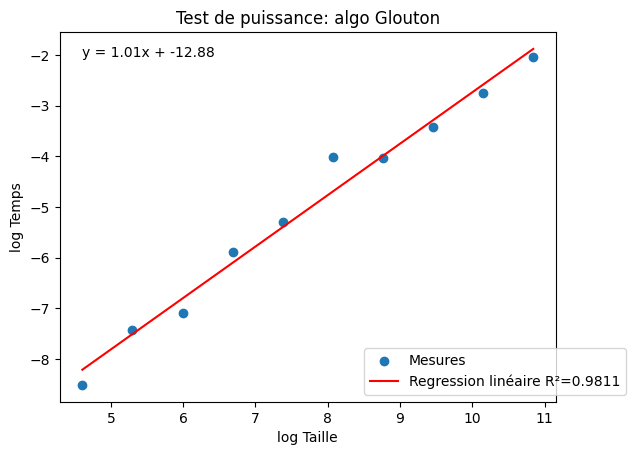

In [64]:
import math

def values_test_puissance(measures):
    return {
        math.log(size) : math.log(measure)
        for size, measure in measures.items()
    }

display_test_puissance(values_test_puissance(measures_glouton), "Test de puissance: algo Glouton")


Test du rapport

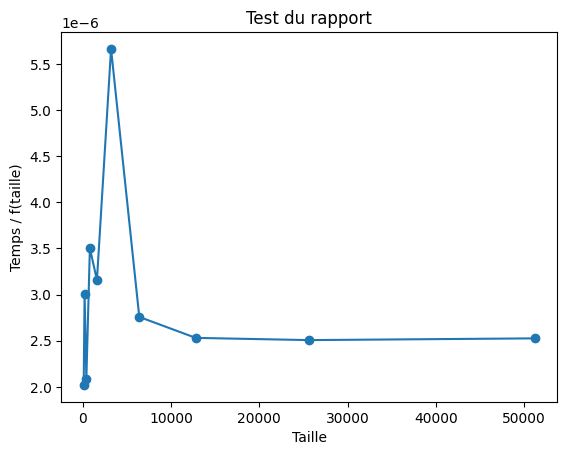

In [65]:
def values_test_rapport(measures, f):
    return {
        size : (measure/f(size))
        for size, measure in measures.items()
    }
#Ici pour f on retourne simplement x, car le seul paramètre qu'on fait varier c'est la taille de la partition, on garde le nombre de doigts constant à 5.
def f(x):
    return x

display_test_rapport(values_test_rapport(measures_glouton, f))

Test des constantes

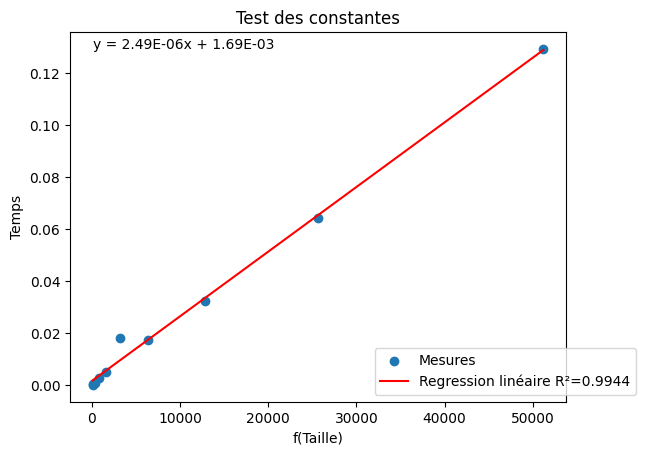

In [68]:
def values_test_contantes(measures, f):
    return {
        f(size) : measure
        for size, measure in measures.items()
    }

def f(x):
    return x

display_test_constantes(values_test_contantes(measures_glouton, f))

Avec le test de puissance, le test du rapport et le test des constantes, nous pouvons valider de manière empirique que la complexité temporelle de notre algorithme est bien O(n), où n est la longueur de la partition, lorsqu'on garde le nombre de doigts constants à 5. Les résultats de nos tests empiriques sont en accord avec notre analyse asymptotique théorique. Le test de puissance nous a permis de confirmer que la complexité temporelle de notre algorithme est bien O(n) avec D constant, puisque la pente du graphique est de 1. Le test du rapport nous a permis de confirmer que notre hypothèse est valide puisque le graphique converge vers une valeur qui est plus grand que 0. Le test des constantes nous a permis de valider nos hypothèses puisque le résultat est une droite, ce qui est le résultat attendu avec une valeur d'ordonné à l'origine de 1.69E-03. C'était le résultat à quoi on s'attendait, puisque nous faisons que varier la taille de la partition ici, alors le D sera toujours égale à 5, soit constant et la seule variation sera au niveau de la taille de la partition.

## Partie 2 : Algorithme de programmation dynamique

L'algorithme de programmation dynamique remplit un tableau des coûts de transition optimaux en
fonction de la mélodie.

Notons `J(k, d)` la somme minimale des coût de transition associée à la mélodie `(ak, ... , an−1)` (c’est-à-
dire au suffixe de longueur `n - k` de la mélodie de départ) où l’on joue la première note ak avec le doigt
d.

Alors, J vérifie la relation de récurrence (1) :

J(k, d) = min { 0≤ d’ ≤ D-1} [ C(ak, d, ak+1, d’ ) + J(k + 1, d’ ) ]

et la condition terminale (2) :

J(n - 1, d) = 0, ∀d = 0, ... , D - 1

Comme on ne connaît pas le premier doigt à utiliser a priori, la solution au problème original est
donnée par (3) :

min { 0 ≤ d ≤ D-1} J(0, d)

Cette récurrence est résolue par programmation dynamique pour déterminer la solution au problème.
Note : Pour vous aider à vérifier que votre implantation fonctionne correctement, voici deux solutions
que vous devriez obtenir avec cet algorithme (dépendant de votre implantation, il pourrait être possible
que vous arriviez au même coût, mais avec une différente suite de doigts) :

- twinkle_twinkle.txt ; coût = 31; doigts = [0, 0, 4, 3, 4, 4, 3, 2, 2, 1, 1, 0, 1, 0, 4, 4, 3, 3, 2, 2, 0, 4, 4, 3,
3, 2, 2, 1, 0, 0, 4, 3, 4, 4, 3, 2, 2, 1, 1, 0, 1, 0]

- fur_elise.txt ; coût = 1091; doigts = [1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4,
4, 0, 1, 4, 4, 0, 4, 3, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0,4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 3, 3, 3, 4, 0, 1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 0, 1, 3, 4, 0, 4, 0,
1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 3, 3, 3, 4, 0, 1, 0, 1, 0, 1, 0, 4,
4, 4, 0, 1, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 4, 3, 2, 0, 1, 2, 0, 1, 0, 2, 1, 1, 0, 4, 4, 4, 3,
2, 1, 0, 1, 0, 0, 2, 1, 0, 0, 1, 2, 3, 3, 4, 3, 4, 0, 1, 2, 0, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 1, 0, 4, 4, 4, 4, 3, 2, 1,
0, 4, 3, 1, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 1, 0, 4, 4, 4, 4, 3, 2, 1, 0, 2, 1, 0, 1, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4,
4, 0, 4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 4]

Implantez l'algorithme de programmation dynamique.

Coût Programmation Dynamique : 31


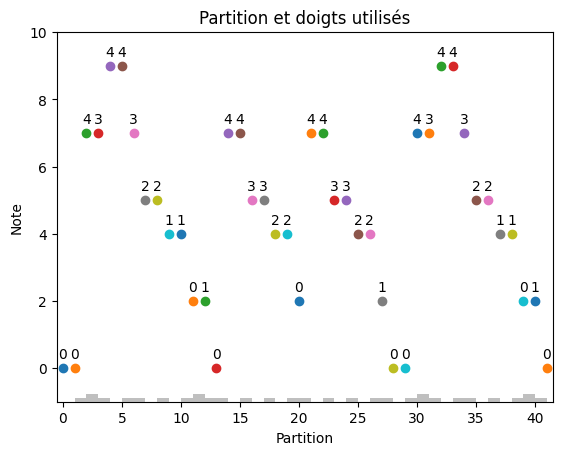

In [51]:
def progDyn(partition, doigts: int = D ):
    solution = [0 for _ in range(len(partition))]
    table_J = [[0 for _ in range(doigts)] for _ in range(len(partition))]
    finger_choice = [[0 for _ in range(doigts)] for _ in range(len(partition))]
    #filling the table_J 2D array
    for i in range(len(partition) - 2, -1, -1):
        for finger in range(doigts):
            finger_costs = [(costs[partition[i], finger, partition[i + 1], d] + table_J[i + 1][d]) for d in range(D)]
            min_index = finger_costs.index(min(finger_costs))
            table_J[i][finger] = min(finger_costs)
            finger_choice[i][finger] = min_index

    #Retracing to get the optimal sequence that gave us the minimum at table_J[0]
    min_index = table_J[0].index(min(table_J[0]))
    for k in range(len(partition)):
        solution[k] = min_index
        min_index = finger_choice[k][min_index]

    return solution
partition = readFile('Chansons/twinkle_twinkle.txt')
solutionDyn = progDyn(partition)
print("Coût Programmation Dynamique :", getTotalCost(costs, partition, solutionDyn))
visualize_solution(costs, partition, solutionDyn)

### Analyse asymptotique

Dans cette analyse, vous tiendrez compte à la fois de la longueur de la mélodie mais également du
nombre de doigts pour chacun des trois algorithmes.

La complexité temporelle dépend de la longueur de la partition passé en paramètre ainsi que du nombre de doigts. Dans notre algorithme, nous avons une boucle principale qui itère sur la longueur de la partition et deux boucles imbriqués qui itère sur le nombre de doigts. Alors, puisque nous avons une boucle principale qui itère sur la longueur de la partition et deux boucles qui itèrent sur le nombre de doigts, la complexité temporelle de notre algorithme est O(n * D²), où n est la longueur de la partition et D est le nombre de doigts. Le reste des opérations faites à l'intérieur des boucles sont faites en temps constant. Aussi, nous avons le remplissage des 3 tableaux en début d'algorithme qui se fait en O(3 * n * D), alors en O(n*D) et la construction de la solution qui se fait en O(n) puisqu'elle itère sur la longueur de la partition. Ce qui donne une complexité temporelle total de O(n*D² + n*D + n), ce qui est équivalent à O(n*D²). 


### Mesures

Rapportez dans un tableau les temps d'exécutions moyens avec les fonctions auxiliaires `measure_procedure` et `display_measure_table`

In [70]:
measures_prog_dynamique = measure_procedure(progDyn, dataset)
measures_prog_dynamique
display_measures_table(measures_prog_dynamique)

Taille       Temps moyen (s)5 of size 51200...          
100          0.0009131431579589844
200          0.0021028518676757812
400          0.0046574115753173825
800          0.010467815399169921
1600         0.016402053833007812
3200         0.034333658218383786
6400         0.06741218566894532
12800        0.1602816104888916
25600        0.29703435897827146
51200        0.6139122009277344


### Validation empirique

Servez-vous de vos temps d'exécution pour confirmer et/ou préciser l'analyse asymptotique théorique de vos algorithmes avec la méthode hybride de votre choix.

La méthode peut varier d'un algorithme à l'autre. Justifiez les choix ici et avec des graphiques.

**À noter** : Encore une fois, pour la validation empirique, le seule paramètre que nous faisons varier sera la taille de la partition. Nous allons garder le nombre de doigts constant à 5. Alors, il est normal que dans notre validation nous nous attendons à une complexité de O(n), où n est la taille de la partition, puisque nous faisons varier seulement la taille de la partition.

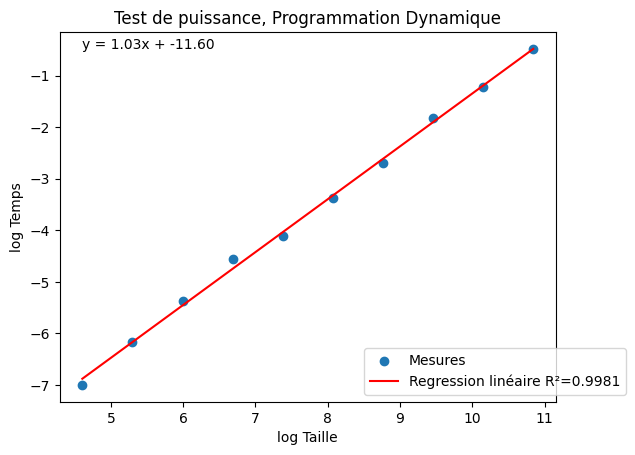

In [71]:
display_test_puissance(values_test_puissance(measures_prog_dynamique), "Test de puissance, Programmation Dynamique")

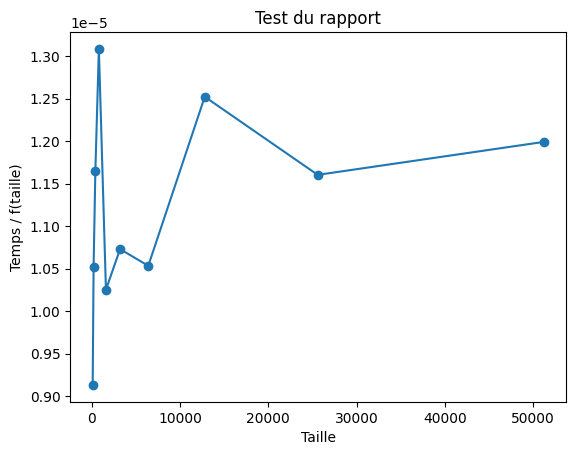

In [72]:
def f_prog_dyn(x):
    return x

display_test_rapport(values_test_rapport(measures_prog_dynamique, f_prog_dyn))

*Insérer votre réponse ici*

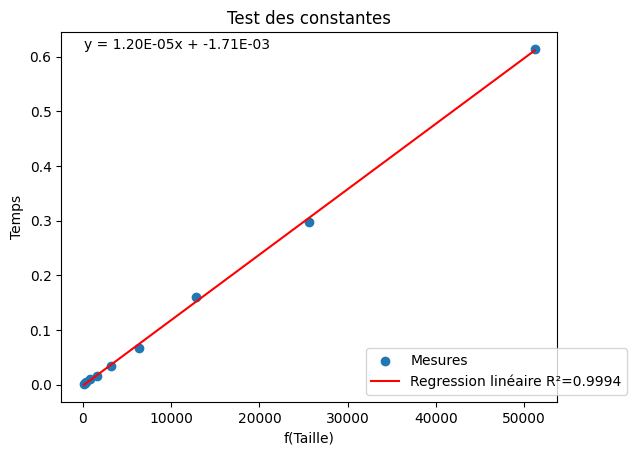

In [73]:
display_test_constantes(values_test_contantes(measures_prog_dynamique, f_prog_dyn))

Avec le test de puissance, le test du rapport et le test des constantes, nous pouvons valider de manière empirique que la complexité temporelle de notre algorithme est bien O(n), où n est la longueur de la partition, lorsqu'on garde le nombre de doigts constants à 5. Les résultats de nos tests empiriques sont en accord avec notre analyse asymptotique théorique. Le test de puissance nous a permis de confirmer que la complexité temporelle de notre algorithme est bien O(n) avec D constant, puisque la pente du graphique est de 1. Le test du rapport nous a permis de confirmer que notre hypothèse est valide puisque le graphique converge vers une valeur qui est plus grand que 0. Le test des constantes nous a permis de valider notre hypothèse puisque le résultat est une droite, ce qui est le résultat attendu avec une valeur d'ordonné à l'origine de 1.69E-03. C'était le résultat à quoi on s'attendait, puisque nous faisons que varier la taille de la partition ici, alors le D sera toujours égale à 5 et donc le D² aussi sera toujours 25, soit constant et la seule variation sera au niveau de la taille de la partition.

## Partie 3 : Algorithme de recherche locale

Cet algorithme explore le voisinage de solutions non optimales. En partant d’une solution gloutonne, la
solution est améliorée en tentant d’échanger un doigt pour un autre sur une note. Vous pourrez prendre
comme critère d’arrêt un nombre maximal d’itérations.

In [ ]:
def localSearch(partition):
    solution = [0 for i in range(len(partition))]
    return solution

solutionLocal = localSearch(partition)
print("Coût Recherche Locale :", getTotalCost(costs, partition, solutionLocal))
visualize_solution(costs, partition, solutionLocal)

### Analyse asymptotique

Dans cette analyse, vous tiendrez compte à la fois de la longueur de la mélodie mais également du
nombre de doigts pour chacun des trois algorithmes.

*Insérer votre réponse ici*

### Mesures

Rapportez dans un tableau les temps d'exécutions moyens avec les fonctions auxiliaires `measure_procedure` et `display_measure_table`

### Validation empirique

Servez-vous de vos temps d'exécution pour confirmer et/ou préciser l'analyse asymptotique théorique de vos algorithmes avec la méthode hybride de votre choix.

La méthode peut varier d'un algorithme à l'autre. Justifiez les choix ici et avec des graphiques.

*Insérer votre réponse ici*

# Conclusion et synthèse

Résumez succintement vos résultats et indiquez sous quelles conditions vous utiliseriez chacun des algorithmes.

*Insérer votre réponse ici*